In [11]:
import pandas as pd    ###dataread###（1〜4行目と出力の上5行くらいを図示）
data  = pd.read_csv("sensor_data_200.txt", delimiter=" ", 
                    header=None, names = ("date","time","ir","lidar"))
data

,date,time,ir,lidar
0,20180122,95819,305,214
1,20180122,95822,299,211
2,20180122,95826,292,199
3,20180122,95829,321,208
4,20180122,95832,298,212
...,...,...,...,...
58983,20180124,120023,313,208
58984,20180124,120026,297,200
58985,20180124,120030,323,204
58986,20180124,120033,326,207


## データの説明
データをとった日付を```date```<br>
データをとった時刻を```time```<br>
200mm先の壁をLiDARで一点のみ採取したものを```lidar```<br>
200mm先の壁を光センサ[1]を```ir```<br>
<br>
[1] 赤外線LEDを前方の壁に向けて照射し、反射してきた赤外線の強さをフォトトランジスタで受けたもの

In [12]:
print(data["lidar"][0:5]) ###getvalues###

0    214
1    211
2    199
3    208
4    212
Name: lidar, dtype: int64


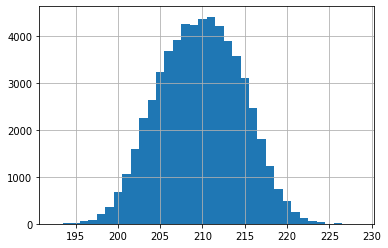

In [13]:
import matplotlib.pyplot as plt
data["lidar"].hist(bins = max(data["lidar"]) - min(data["lidar"]),align='left')
plt.show()

## 誤差の存在
LiDARを動かしたわけでもないのに値に変動がある<br>
外から入る外乱光や電気回路中の電圧や電流を乱す何かが影響して起こる<br>
このような値の変動を<em>**雑音(ノイズ)**</em>と呼ぶ<br>
測りたい「真の」値とセンサ値の差を<em>**誤差**<em><br>
雑音によって発生する誤差を<em>**偶然誤差（accidental error/random error）**</em><br>
欲しいものはロボットと壁の距離 200mmだがロボットとLiDARの取り付けが少しズレており、<br>
雑音を完全に取り除けても210mmを出力するかもしれない<br>
これを<em>**偏り（バイアス）**</em>と呼ぶ<br>
またバイアスによる定常的な誤差のことを<em>**系統誤差（systematic error）**</em>と呼ぶ<br>
系統誤差はセンサ値から推測できないが常に存在を頭の隅においてアルゴリズムを考える必要がある

### まずは雑音の傾向を探ってみる
<em>**平均値**</em>

In [14]:
mean1 = sum(data["lidar"].values)/len(data["lidar"].values)   ###calcmean###
mean2 = data["lidar"].mean()
print(mean1,mean2)

209.73713297619855 209.73713297619855


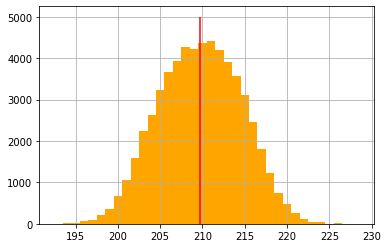

In [15]:
data["lidar"].hist(bins = max(data["lidar"]) - min(data["lidar"]),color="orange",align='left')   ###avgplot###
plt.vlines(mean1,ymin=0,ymax=5000,color="red")
plt.show()

続いてばらつき具合を表す分散<br>
分散には<em>**標本分散**</em>と<em>**不偏分散**</em>の２種類がある<br>
両者はN数が1000くらいになる時にはほとんど差が出ない<br>
N数が小さいとき標本分散は本来の分散よりも少し値が小さくなるという傾向があり、不偏分散ではこれが是正されている<br>

In [16]:
# 定義から計算　                     ### calcvar
zs = data["lidar"].values  
mean = sum(zs)/len(zs)
diff_square = [ (z - mean)**2 for z in zs]

sampling_var = sum(diff_square)/(len(zs))     # 標本分散
unbiased_var = sum(diff_square)/(len(zs)-1) # 不偏分散

print(sampling_var)
print(unbiased_var)

# Pandasを使用
pandas_sampling_var = data["lidar"].var(ddof=False) # 標本分散
pandas_default_var = data["lidar"].var()        # デフォルト（不偏分散）

print(pandas_sampling_var)
print(pandas_default_var)

# NumPyを使用
import numpy as np

numpy_default_var = np.var(data["lidar"])  # デフォルト（標本分散）
numpy_unbiased_var = np.var(data["lidar"], ddof=1)  # 不偏分散

print(numpy_default_var)
print(numpy_unbiased_var)

23.407709770274106
23.40810659855441
23.4077097702742
23.408106598554504
23.4077097702742
23.408106598554504


## 問題 2.1
上のデータからn個の標本を抽出するプログラムをかいて、さらに次のプログラムを実行せよ<br>
a. n=3で標本を抽出し、標本分散を求めよ<br>
b. a.を10,000回繰り返し、標本分散の平均値を求めよ<br>
c. n=3で標本を抽出し、不偏分散を求めよ<br>
d. c.を10,000回繰り返し、不偏分散の平均値を求めよ<br>

In [17]:
def extract(data,n):
    return data.sample(n=n)

In [18]:
pb2_1_a = extract(data,3)
print("標本分散(n=3):"+str(pb2_1_a['lidar'].var(ddof=False)))

標本分散(n=3):18.0


In [19]:
pb2_1_b = [ extract(data,3)['lidar'].var(ddof=False) for i in range(10000) ]
print("標本分散(n=3)の10000回平均:"+str(np.mean(pb2_1_b)))

標本分散(n=3)の10000回平均:15.627911111111109


In [20]:
pb2_1_c = extract(data,3)
print("不偏分散(n=3):"+str(pb2_1_c['lidar'].var()))

不偏分散(n=3):44.33333333333333


In [21]:
pb2_1_d = [ extract(data,3)['lidar'].var() for i in range(10000) ]
print("不偏分散(n=3)の10000回平均:"+str(np.mean(pb2_1_d)))

不偏分散(n=3)の10000回平均:23.7565


In [22]:
import math ###  calcstddev

# 定義から計算
stddev1 = math.sqrt(sampling_var)
stddev2 = math.sqrt(unbiased_var)

# Pandasを使用 
pandas_stddev = data["lidar"].std()

print(stddev1)
print(stddev2)
print(pandas_stddev)

4.838151482774605
4.83819249292072
4.838192492920729


In [23]:
data.describe()

,date,time,ir,lidar
count,5.898800e+04,58988.000000,58988.000000,58988.000000
mean,2.018012e+07,117591.959144,308.681851,209.737133
std,7.202676e-01,67837.713969,10.459187,4.838192
min,2.018012e+07,0.000000,283.000000,193.000000
25%,2.018012e+07,61542.250000,300.000000,206.000000
50%,2.018012e+07,113958.500000,308.000000,210.000000
75%,2.018012e+07,174442.750000,317.000000,213.000000
max,2.018012e+07,235959.000000,338.000000,229.000000


## 確率分布

In [24]:
freqs = pd.DataFrame(data["lidar"].value_counts())  ###freqs###
freqs.transpose() #横向きに出力してみましょう

,211,210,208,209,212,207,213,206,214,205,...,197,196,223,224,226,195,194,193,227,229
lidar,4409,4355,4261,4228,4201,3920,3897,3674,3572,3225,...,84,59,55,32,15,13,10,4,3,1


In [25]:
freqs["probs"] = freqs["lidar"]/len(data["lidar"]) ###addprobs###
freqs.transpose()

,211,210,208,209,212,207,213,206,214,205,...,197,196,223,224,226,195,194,193,227,229
lidar,4409.000000,4355.000000,4261.000000,4228.000000,4201.000000,3920.000000,3897.000000,3674.000000,3572.000000,3225.000000,...,84.000000,59.000,55.000000,32.000000,15.000000,13.00000,10.00000,4.000000,3.000000,1.000000
probs,0.074744,0.073829,0.072235,0.071676,0.071218,0.066454,0.066064,0.062284,0.060555,0.054672,...,0.001424,0.001,0.000932,0.000542,0.000254,0.00022,0.00017,0.000068,0.000051,0.000017


確率の合計は１になっている

In [26]:
sum(freqs["probs"])  ###confirmsum###

1.0

個別のP(z)を与える関数Pを描いたものとして<em>**確率質量関数**</em>（連続値なら<em>**確率密度関数**</em>）<br>
変数に対する確率の分布を表すものとして<em>**確率分布**</em>

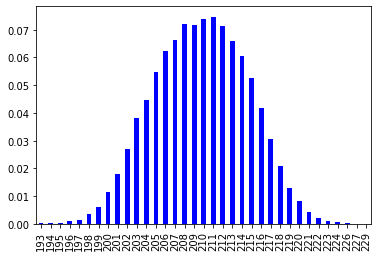

In [27]:
freqs["probs"].sort_index().plot.bar(color="blue")   ###probdist###
plt.show()

## 確率分布を用いたシミュレーション

$
    z_{N} \sim P_{\boldsymbol{Z}_{LiDAR}}
$<br>
確率分布に従ってzを取り出すことを**ドロー**するという(**ドローイング**)<br>
**サンプリング**は個々のものを抽出するときは使わず、母集団から集団の一部を抽出することを指す

In [28]:
def drawing(): #ややこしいので関数として定義  ###one_sampling###
    return freqs.sample(n=1, weights="probs").index[0]

drawing() # 実行

213

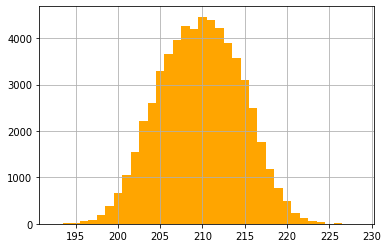

In [29]:
samples = [ drawing() for i in range(len(data))] ### sampling_simulation ###
#samples = [ drawing() for i in range(100)] #コーディング中は1行目の代わりにこちらを使う
simulated = pd.DataFrame(samples, columns=["lidar"])
p = simulated["lidar"]
p.hist(bins = max(p) - min(p),color="orange",align='left')  
plt.show()

$P(225)=0$だったからといって$ P_{\boldsymbol{Z}_{LiDAR}}(225)=0 $とするのは正しいのか？<br>
これは分布の形をみて「真の確率分布の姿」を想像するために発生する疑問<br>
確率・統計を勉強した人は<em>**ガウス分布**</em>に従っていると考える<br>
ここでは一旦それを正しいとして話を進める

## ガウス分布の当てはめ

$
    P(a \leq z < b) = \int_{a}^{b} p(z) dz \\
    p(z) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{ \{ -\frac{(z-\mu)^2}{2\sigma^2} \}}
$<br>
<br>
<br>
$\sigma^2$を分散、$\mu$を平均値とする<br>
また、分散と平均値を決めると形が決まるのでこれを以下で略記することもある<br>
<br>
$
\mathit{N}(z|\mu,\sigma^2)
$
<br>
<br>
このようにある現象を説明するために適切な確率分布の数式を持ってきてパラメータを求めることを**モデル化**と呼び、モデル化で分布に当てはめられる数式は**確率モデル**という

In [30]:
def p(z, mu=209.7, dev=23.4):   ###pdf_from_def###
    return math.exp(-(z - mu)**2/(2*dev))/math.sqrt(2*math.pi*dev)

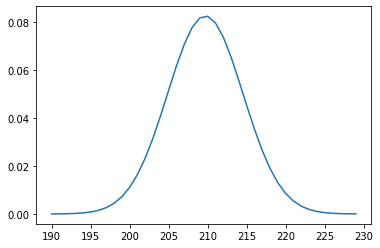

In [31]:
zs = range(190,230)   ###pdf_plot_from_def###
ys = [p(z) for z in zs]

plt.plot(zs,ys)
plt.show()

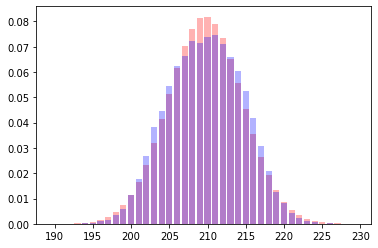

In [32]:
def prob(z,width=0.5):                                     ###prob_plot_from_def###
    # 台形公式で積分を近似
    return width*( p(z-width) + p(z+width) )

zs = range(190,230)
ys = [prob(z) for z in zs]

plt.bar(zs,ys, color="red", alpha=0.3) #alphaでグラフを透明にできる
f = freqs["probs"].sort_index()
plt.bar(f.index, f.values, color="blue", alpha=0.3)
plt.show()

$
    p(z) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{ \{ -\frac{(z-\mu)^2}{2\sigma^2} \}}
$<br>
これはガウス分布の確率密度関数であり、積分すると確率が出てくる<br>
その値は密度と呼ばれる<br>
センサが実数の時、値がピッタリ200とかになる確率はゼロであり、値の範囲を与えて積分して取り出す<br>
この範囲を微小にして微分したものが確率密度関数<br>
確率密度関数はScipyが便利<br>

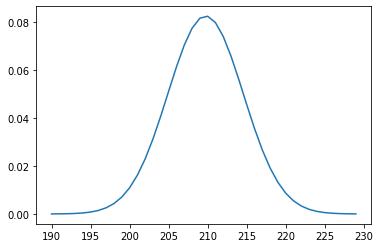

In [34]:
from scipy.stats import norm    ###pdf_plot_from_lib###

zs = range(190,230)
# norm.pdfがガウス分布の確率密度関数(probablity density function)
ys = [norm.pdf(z, mean1, stddev1) for z in zs]

plt.plot(zs,ys)
plt.show()

累積分布関数
$
    P(z < a) = \int_{-\infty}^{a} p(z) dz \\
$

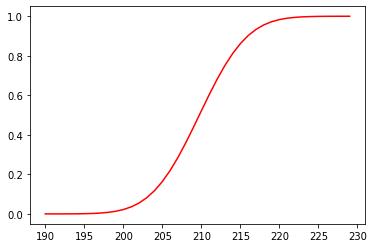

In [35]:
zs = range(190,230)                                ###cdf###
# cdf(cumulative distribution function)
ys = [norm.cdf(z, mean1, stddev1) for z in zs]

plt.plot(zs,ys, color="red") 
plt.show()

さっきの台形公式による近似は以下で再現できる<br>
$
    P(a \leq z <  b) = P(z<b)-P(z<a) \\
$

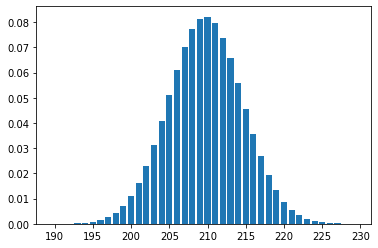

In [36]:
zs = range(190,230)              ###prob_cdf###
ys = [norm.cdf(z+0.5, mean1, stddev1) -  norm.cdf(z-0.5, mean1, stddev1) for z in zs]

plt.bar(zs,ys)
plt.show()

## 問題2.2
次のようにセンサの雑音をシミュレーションしてみる<br>
1. サイコロを10個振る<br>
2. 値の合計に200を足す<br>
3. 手順1,2を10,000回繰り返し、ヒストグラムを描く<br>
<br>
この問題は**中心極限定理**の一例となっている.<br>
平均が$\mu$、分散が$\sigma^2$の確率分布から$x_1,x_2,....,x_n$と標本抽出をn回繰り返して数字を得て、さらにそれの平均値$\bar{x}$の算出を繰り返し他時、nの値が大きい場合、$\bar{x}$の分布が平均値$\mu$、分散$\sigma^2/n$のガウス分布に近似的に従う<br>
センサ値のばらつきがガウス分布に従うことが多い背景にはこの中心極限定理がある.ばらつきの要因の１つ１つから生じる雑音はさまざまな分散や偏りを物が、他より極端に大きな要因がない限り、最終的にはばらつきはガウス分布に近づく

In [37]:
import random
def saikoro():
    return random.randint(1,6)

In [48]:
pb2_2 = [ sum([ saikoro() for i in range(10) ])+200 for j in range(10000) ]
pb2_2_saiko = [ [ saikoro() for i in range(10) ] for j in range(10000) ]

In [39]:
df_pb2_2 = pd.DataFrame(pb2_2)

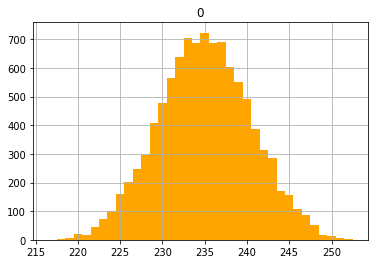

In [46]:
df_pb2_2.hist(bins = max(df_pb2_2[0]) - min(df_pb2_2[0]),color="orange",align='left')  
plt.show()

In [51]:
np.mean(pb2_2_saiko)

3.49946

In [55]:
np.var(pb2_2_saiko)

2.9142197084

In [52]:
np.mean(pb2_2)

234.9209

In [56]:
np.var(pb2_2)

29.338043190000004

## 問題2.3
LiDARで返してきたセンサ値は整数の離散的なものだった.ガウス分布でモデル化したが、離散的な確率分布である**二項分布**でモデル化すべきかもしれない<br>
二項分布は、例えば成功率$p$の試行をn回行ったとき、x回成功する確率を表す確率分布である.<br>
<br>
$
P(成功x回)={}_n C_xp^x(1-p)^{n-x}
$
<br>
<br>
ここで、n回の試行は互いに独立と仮定されている.また、この分布の平均値$\mu$、分散$\sigma^2$は以下となる.<br>
<br>
$
\mu = np \\
\sigma^2 = np(1-p)
$
<br>
<br>
$\boldsymbol{z}_{LiDAR}$のセンサ値の平均値、分散はそれぞれ209.7\[mm\],23.4だった.センサ値を成功回数xに見立てて、二項分布に当てはめ、描写してみる.


In [78]:
from scipy.special import comb
# n = len(data['lidar'])
n = max(data['lidar'])
pb_2_3_p = (209.7)/n 
def binominal_d(x):
    return comb(int(n),int(x),exact=True)*(pb_2_3_p**x)*((1-pb_2_3_p)**(n-x))

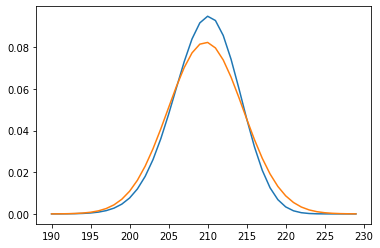

In [88]:
zs = range(190,230)

ys1 = [ binominal_d(z) for z in zs]
ys2 = [norm.pdf(z, mean1, stddev1) for z in zs]

plt.plot(zs,ys1)
plt.plot(zs,ys2)
plt.show()